In [2]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

import django
django.setup()

import os
from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
from django.db.models import Count, Sum, Max, Avg
from django.db.models import When, Case, Value
from django.db.models import IntegerField, FloatField
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest, Coalesce

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
available_dbs = settings.DATABASES.keys()[1:]
PLOTS_PATH = 'Analysis/plots/'
PLOTS_FORMATS = ['.pdf', '.png']

# Threads length (all data)


In [3]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (later must sum 1 for the question)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]

# Thread length VS Nr threads (all data)

In [4]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

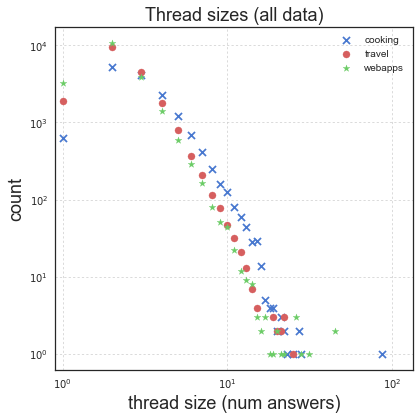

In [5]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)            
plt.title('Thread sizes (all data)', fontsize=18)
ax1.set_xlim(xmin=0.9)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_ALL' + plot_format)

# Thread length VS Nr threads (annotated data)


In [6]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (later must sum 1 for the question)
    
    # note: assumes question and all posts have been annotated (doesn't count answers not annotated)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]
    
    
    
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

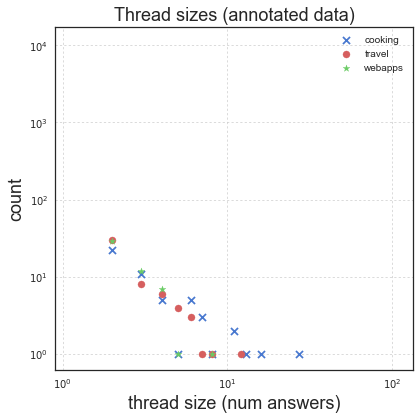

In [7]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)


ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes (annotated data)', fontsize=18)
ax1.set_xlim(xmin=xmin, xmax=xmax)
ax1.set_ylim(ymin=ymin, ymax=ymax)


plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_ANNOTATED' + plot_format)

In [8]:
# Quality distribution VS Threads length

In [9]:
def mean_custon(q_q, a_q, thread_size):
    if (q_q is None and a_q is None):
        return None
    elif (q_q is None and a_q is not None):
        return q_q
    elif (q_q is not None and a_q is None):
        return a_q / float(thread_size)
    elif (q_q is not None and a_q is not None):
        return (q_q + a_q) / float(thread_size)


#
"""
example: {'cooking':
            question_id: {
                    'thread_size: 4,
                    'thread_avg_quality: 1.3
                }
#         }
"""
threads_data = {
    'cooking': {},
    'webapps': {},
    'travel': {}
}


for db in available_dbs:
    #print db

    # STAGE 1: considering (only) actual threads

    questions = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .filter(Q(annotatedqualityenrico__isnull=False) |
                Q(annotatedqualitymarit__isnull=False) |
                Q(annotatedqualitychristine__isnull=False) |
                Q(annotatedqualityhenrik__isnull=False))\
        .values('id',
                'answercount',
                'annotatedqualityenrico')

    answers = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .filter(Q(annotatedqualityenrico__isnull=False) |
                Q(annotatedqualitymarit__isnull=False) |
                Q(annotatedqualitychristine__isnull=False) |
                Q(annotatedqualityhenrik__isnull=False))\
        .values('parentid')\
        .annotate(sum_qual_enrico=Sum('annotatedqualityenrico'))

    for question in questions:
        threads_data[db][int(question['id'])] = {
            'thread_size': question['answercount'] + 1,
            'thread_avg_quality': question['annotatedqualityenrico']
        }

    for answer in answers:
        question_quality = threads_data[db][int(answer['parentid'])]['thread_avg_quality']
        thread_size = threads_data[db][int(answer['parentid'])]['thread_size']
        actual_average = mean_custon(question_quality, answer['sum_qual_enrico'], thread_size)
        threads_data[db][int(answer['parentid'])]['thread_avg_quality'] = actual_average

    #print threads_data[db]



# for each distinct value in [...] count its occurence, zip the result
"""
example:        {
                    'webapps': {
                        't_sizes': array([2,    3,  4,  5,  8]),
                        't_count': array([29,   12, 7,  1,  1])
                        }, {...}
                }
"""
t_length_count = {}

for db in available_dbs:
    #print db
    t_lengths_list = [value['thread_size'] for key, value in threads_data[db].iteritems()]

    # count occurences
    bins = np.bincount(t_lengths_list)
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])

    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes,
        't_avg_qual': []
    }

    for size in t_sizes:
        avg_thread_sizes = []
        for key, value in threads_data[db].iteritems():
            if value['thread_size'] == size:
                avg_thread_sizes.append(value['thread_avg_quality'])
        t_length_count[db]['t_avg_qual'].append(avg_thread_sizes)

In [ ]:
print t_length_count['cooking']
# http://matplotlib.org/examples/pylab_examples/boxplot_demo2.html